In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.quantum_info import SparsePauliOp, entanglement_of_formation, DensityMatrix

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from scipy.optimize import minimize


import numpy as np
import matplotlib.pyplot as plt


from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import Estimator
from qiskit_aer.primitives import EstimatorV2 as EstimatorAer
from qiskit_aer import AerSimulator


from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2,
    SamplerV2 as Sampler,
    EstimatorOptions
)


from qiskit.visualization import plot_distribution

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer



from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint



from entanglement_measures import GHZ_entanglmenetlike_measure, Multipartite_Negativity, multipartite_entanglement

In [12]:

def initialize_H2O_vqe_chemical(intermolecular_distance= 1, bending_angle= np.pi/2 ,mapper= JordanWignerMapper(), basis = 'ccpvdz'):

    xcoord = intermolecular_distance * np.cos(bending_angle/2)
    ycoord = intermolecular_distance * np.sin(bending_angle/2)

    driver = PySCFDriver(atom=f"O 0 0 0; H {xcoord} {ycoord} 0; H {xcoord} {-1 * ycoord} 0", basis=basis)

    full_problem = driver.run()

    #Here the type of molecule is the type A X_2 E_2, which means that it is important to count 
    #The four electrons of free pairs.
    act_space_tf = ActiveSpaceTransformer(num_electrons= 4, num_spatial_orbitals= 4) 

    problem = act_space_tf.transform(full_problem)

    mapper = ParityMapper(num_particles=(problem.num_alpha, problem.num_beta))

    pauli_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())


    #then we generate the Ansatz
    init_state = HartreeFock(problem.num_spatial_orbitals,
                         problem.num_particles,
                         mapper)

    ansatz = UCCSD(problem.num_spatial_orbitals,
               problem.num_particles,
               mapper,
               initial_state= init_state)
    
    return ansatz, pauli_hamiltonian, problem


#@jit
def vqe_chemical_ansatz(estimator, ansatz, problem, mapper=JordanWignerMapper(), optimizer= SLSQP()):
    vqe = VQE(estimator= estimator,
              ansatz= ansatz,
              optimizer= optimizer)

    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem

    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe)

    result = solver.solve(problem)

    gs_energy = result.total_energies[0]
    utilized_ansatz = result.groundstate[0]
    optimized_parameters = result.groundstate[1]

    optimal_ansatz = utilized_ansatz.assign_parameters(optimized_parameters)

    return gs_energy, optimal_ansatz




def run_calculation_for_H2O_gs(swept_interval, angle_interval ,estimator):

    distances = swept_interval
    angles = angle_interval

    num_dist = len( swept_interval )
    num_angl = len( angle_interval)

    shape_of_mesh = (num_angl, num_dist)

    entanglement_list_max = np.zeros(shape= shape_of_mesh)
    entanglement_list_total = np.zeros(shape= shape_of_mesh)

    negativity_list_max = np.zeros(shape= shape_of_mesh)
    negativity_list_total = np.zeros(shape= shape_of_mesh)

    ghz_measure_list = np.zeros(shape= shape_of_mesh)

    energiesH2_list = np.zeros(shape= shape_of_mesh)


    for i, d in enumerate(swept_interval):
        for j, a in enumerate(angle_interval):

            ansatz_h2, pauli_ham_h2, prob = initialize_H2O_vqe_chemical(intermolecular_distance= d,
                                                                       bending_angle= a)

            gs_energy_d, optimal_ansatz_d = vqe_chemical_ansatz(estimator=estimator,
                                                                ansatz= ansatz_h2,
                                                                problem= prob)
        

            r = DensityMatrix(optimal_ansatz_d)

    

            energiesH2_list[i][j] = gs_energy_d

            entanglement_list_max[i][j]  = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'max' )
            entanglement_list_total[i][j] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'total')
        
            """
            negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
            negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
            """
            ghz_measure_list[i][j]  = GHZ_entanglmenetlike_measure(optimal_ansatz_d)

    
    return energiesH2_list, entanglement_list_max, entanglement_list_total, negativity_list_max, negativity_list_total, ghz_measure_list

In [14]:
#from qiskit_aer.primitives import EstimatorV2, Estimator

from qiskit.primitives import Estimator

estimator = Estimator()

d= 1
a = np.pi / 2

ansatz_h2, pauli_ham_h2, prob = initialize_H2O_vqe_chemical(intermolecular_distance= d,
                                                                       bending_angle= a)

gs_energy_d, optimal_ansatz_d = vqe_chemical_ansatz(estimator=estimator,
                                                    ansatz= ansatz_h2,
                                                    problem= prob)

In [15]:
from qiskit_aer.primitives import EstimatorV2
from qiskit_aer import AerSimulator



distances = np.linspace(0.6, 1.25, 5)
angles_interval = np.linspace(np.pi/2, 11 * np.pi/18, num= 5) #from 90° to 110°




energies_H2OV3, entgmax_H2OV3, entgtotal_H2OV3, negmax_H2OV3, negtotal_H2OV3, ghzmeasure_H2OV3 = run_calculation_for_H2O_gs(swept_interval= distances, angle_interval= angles_interval ,estimator= estimator)

In [77]:
%store data_first_sim_H2O

Stored 'data_first_sim_H2O' (list)


/home/herbert/workspace/vqe_venv/lib/python3.11/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/data_first_sim_H2O requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


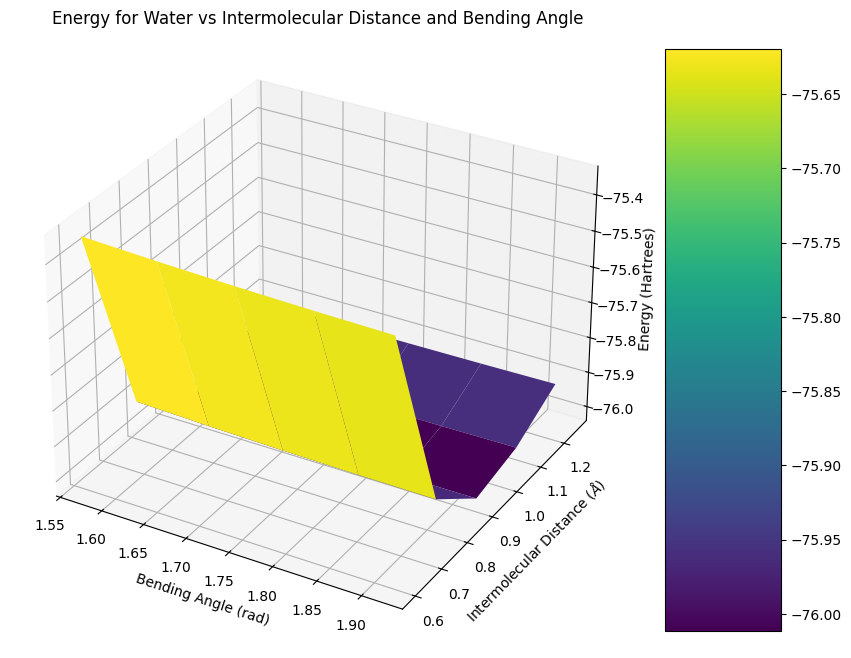

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

# Enable interactive mode
#%matplotlib widget

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')



angles_grid, distances_grid = np.meshgrid(angles_interval, distances)

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method
energies = energies_H2OV3

# Plot surface
surf = ax.plot_surface(angles_grid, distances_grid, energies, cmap='viridis')

# Customize plot
ax.set_xlabel(r'Bending Angle (rad)')
ax.set_ylabel(r'Intermolecular Distance ($\AA$)')
ax.set_zlabel('Energy (Hartrees)')
ax.set_title('Energy for Water vs Intermolecular Distance and Bending Angle')



# Add color bar
fig.colorbar(surf, ax=ax, shrink=4, aspect=5)

plt.show()

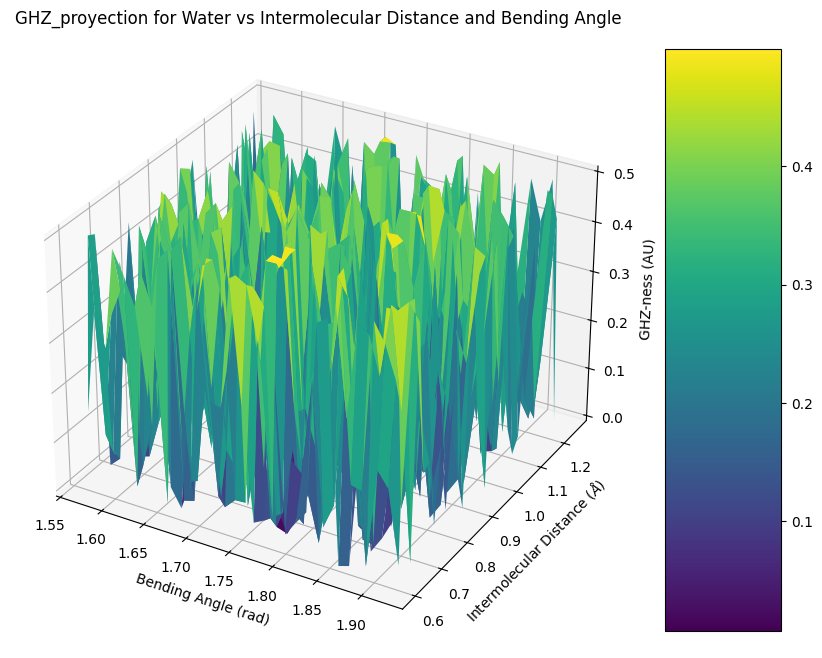

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

# Enable interactive mode
#%matplotlib widget

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')



angles_grid, distances_grid = np.meshgrid(angles_interval, distances)

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method
data = (entgmax_H2OV3, entgtotal_H2OV3, negmax_H2OV3, negtotal_H2OV3, ghzmeasure_H2OV3)


Z = ghzmeasure_H2OV3


# Plot surface
surf = ax.plot_surface(angles_grid, distances_grid, Z, cmap='viridis')

# Customize plot
ax.set_xlabel(r'Bending Angle (rad)')
ax.set_ylabel(r'Intermolecular Distance ($\AA$)')
ax.set_zlabel('GHZ-ness (AU)')
ax.set_title('GHZ_proyection for Water vs Intermolecular Distance and Bending Angle')



# Add color bar
fig.colorbar(surf, ax=ax, shrink=4, aspect=5)

plt.show()

In [78]:
print(np.min(energies_H2O))

-76.00216210245323


(15, 29)


In [86]:
print(distances[15])
print(angles_interval[26])

0.9362068965517241
1.8837519168076726


[16 20]


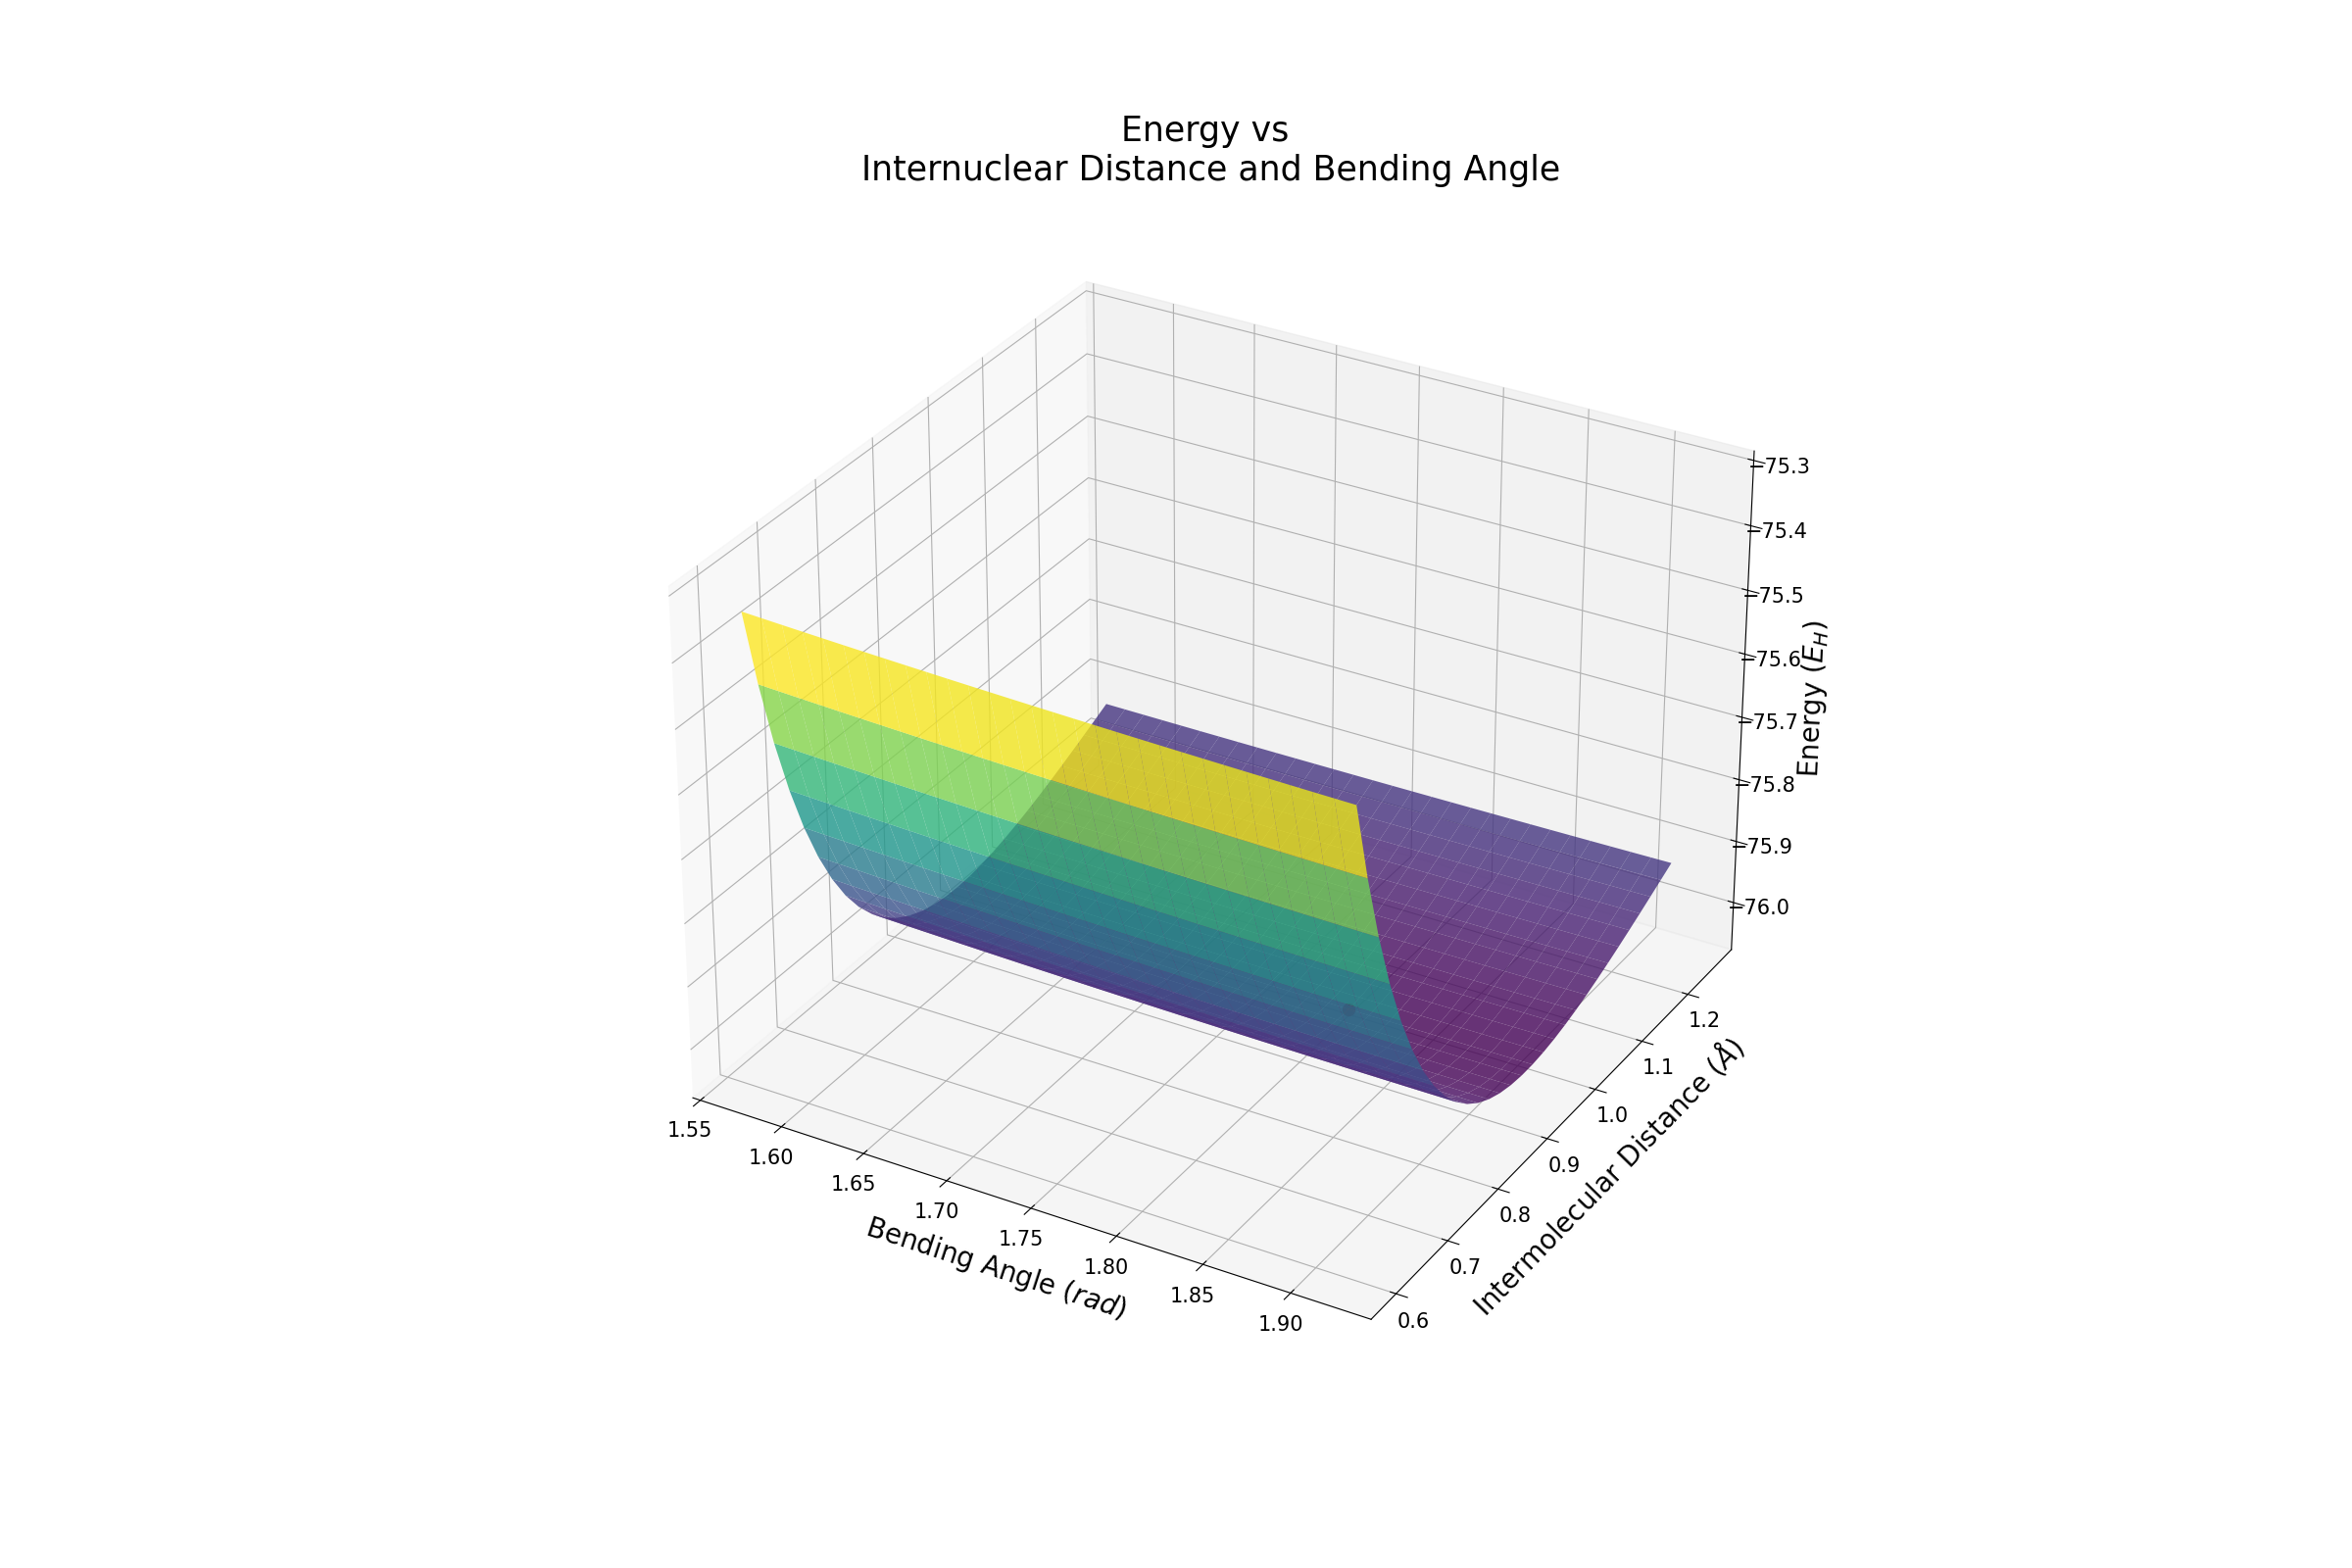

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

# Enable interactive mode
%matplotlib widget




fig = plt.figure(figsize=(24, 16))
ax = fig.add_subplot(111, projection='3d')



angles_grid, distances_grid = np.meshgrid(angles_interval, distances)

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method
energies = energies_H2OV3

# Plot surface
surf = ax.plot_surface(angles_grid, distances_grid, energies, cmap='viridis', alpha= 0.8)

# Customize plot
ax.set_xlabel('\nBending Angle ($rad$)',fontsize= 20)
ax.set_ylabel('\nIntermolecular Distance ($\AA$)', fontsize= 20)
ax.set_zlabel('\nEnergy ($E_H$)', fontsize= 20)
ax.set_title('Energy vs\n Internuclear Distance and Bending Angle', fontsize= 25)

point_z = np.min(energies_H2OV3)

xy = np.argwhere(energies == point_z)[0]

point_y = distances[xy[0]]
point_x = angles_interval[xy[1]]

print(xy)

ax.scatter(point_x, point_y, point_z, color='red', s=75)



plt.tick_params(axis='both', which='major', labelsize=15)  # Change the label size here

# Add color bar
#fig.colorbar(surf, ax=ax)

plt.show()

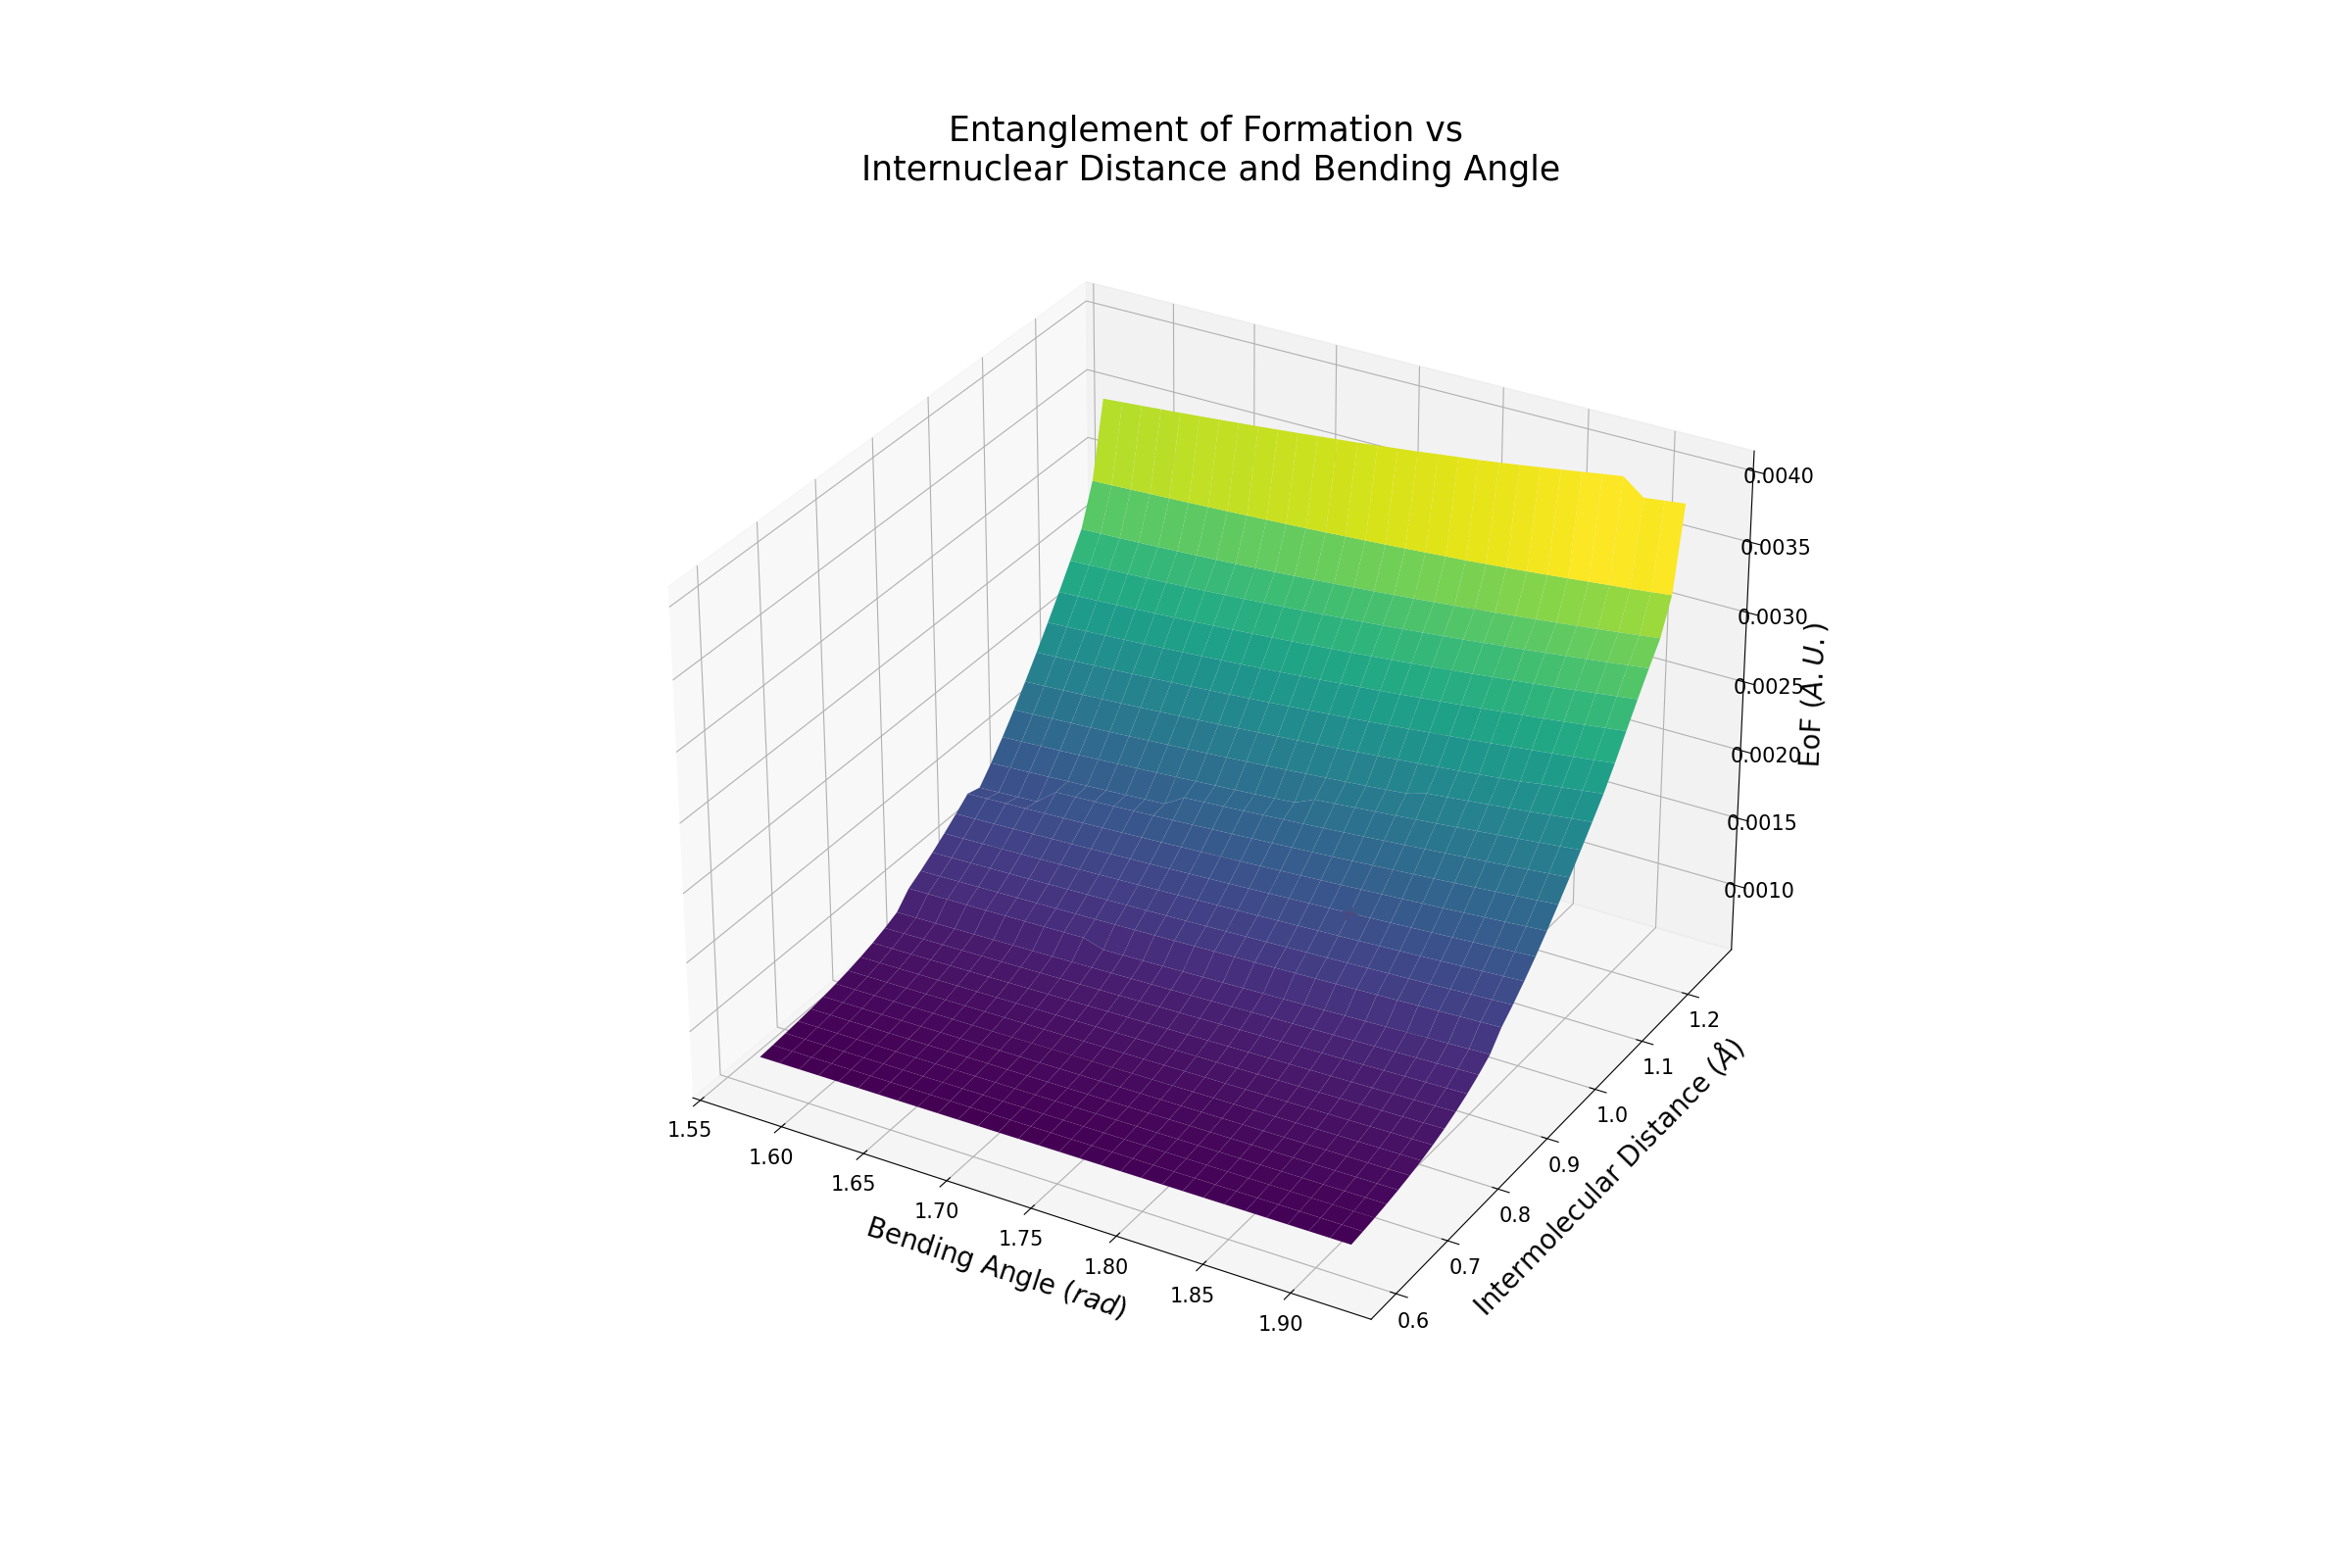

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

# Enable interactive mode
%matplotlib widget




fig = plt.figure(figsize=(24, 16))
ax = fig.add_subplot(111, projection='3d')



angles_grid, distances_grid = np.meshgrid(angles_interval, distances)

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method
energies = entgmax_H2OV3

# Plot surface
surf = ax.plot_surface(angles_grid, distances_grid, energies, cmap='viridis', alpha= 1)

# Customize plot
ax.set_xlabel('\nBending Angle ($rad$)',fontsize= 20)
ax.set_ylabel('\nIntermolecular Distance ($\AA$)', fontsize= 20)
ax.set_zlabel('\n EoF ($A.U.$)', fontsize= 20)
ax.set_title('Entanglement of Formation vs\n Internuclear Distance and Bending Angle', fontsize= 25)

point_z = energies[16][20]



ax.scatter(point_x, point_y, point_z, color='red', s=100)



plt.tick_params(axis='both', which='major', labelsize=15)  # Change the label size here

# Add color bar
#fig.colorbar(surf, ax=ax)

plt.show()

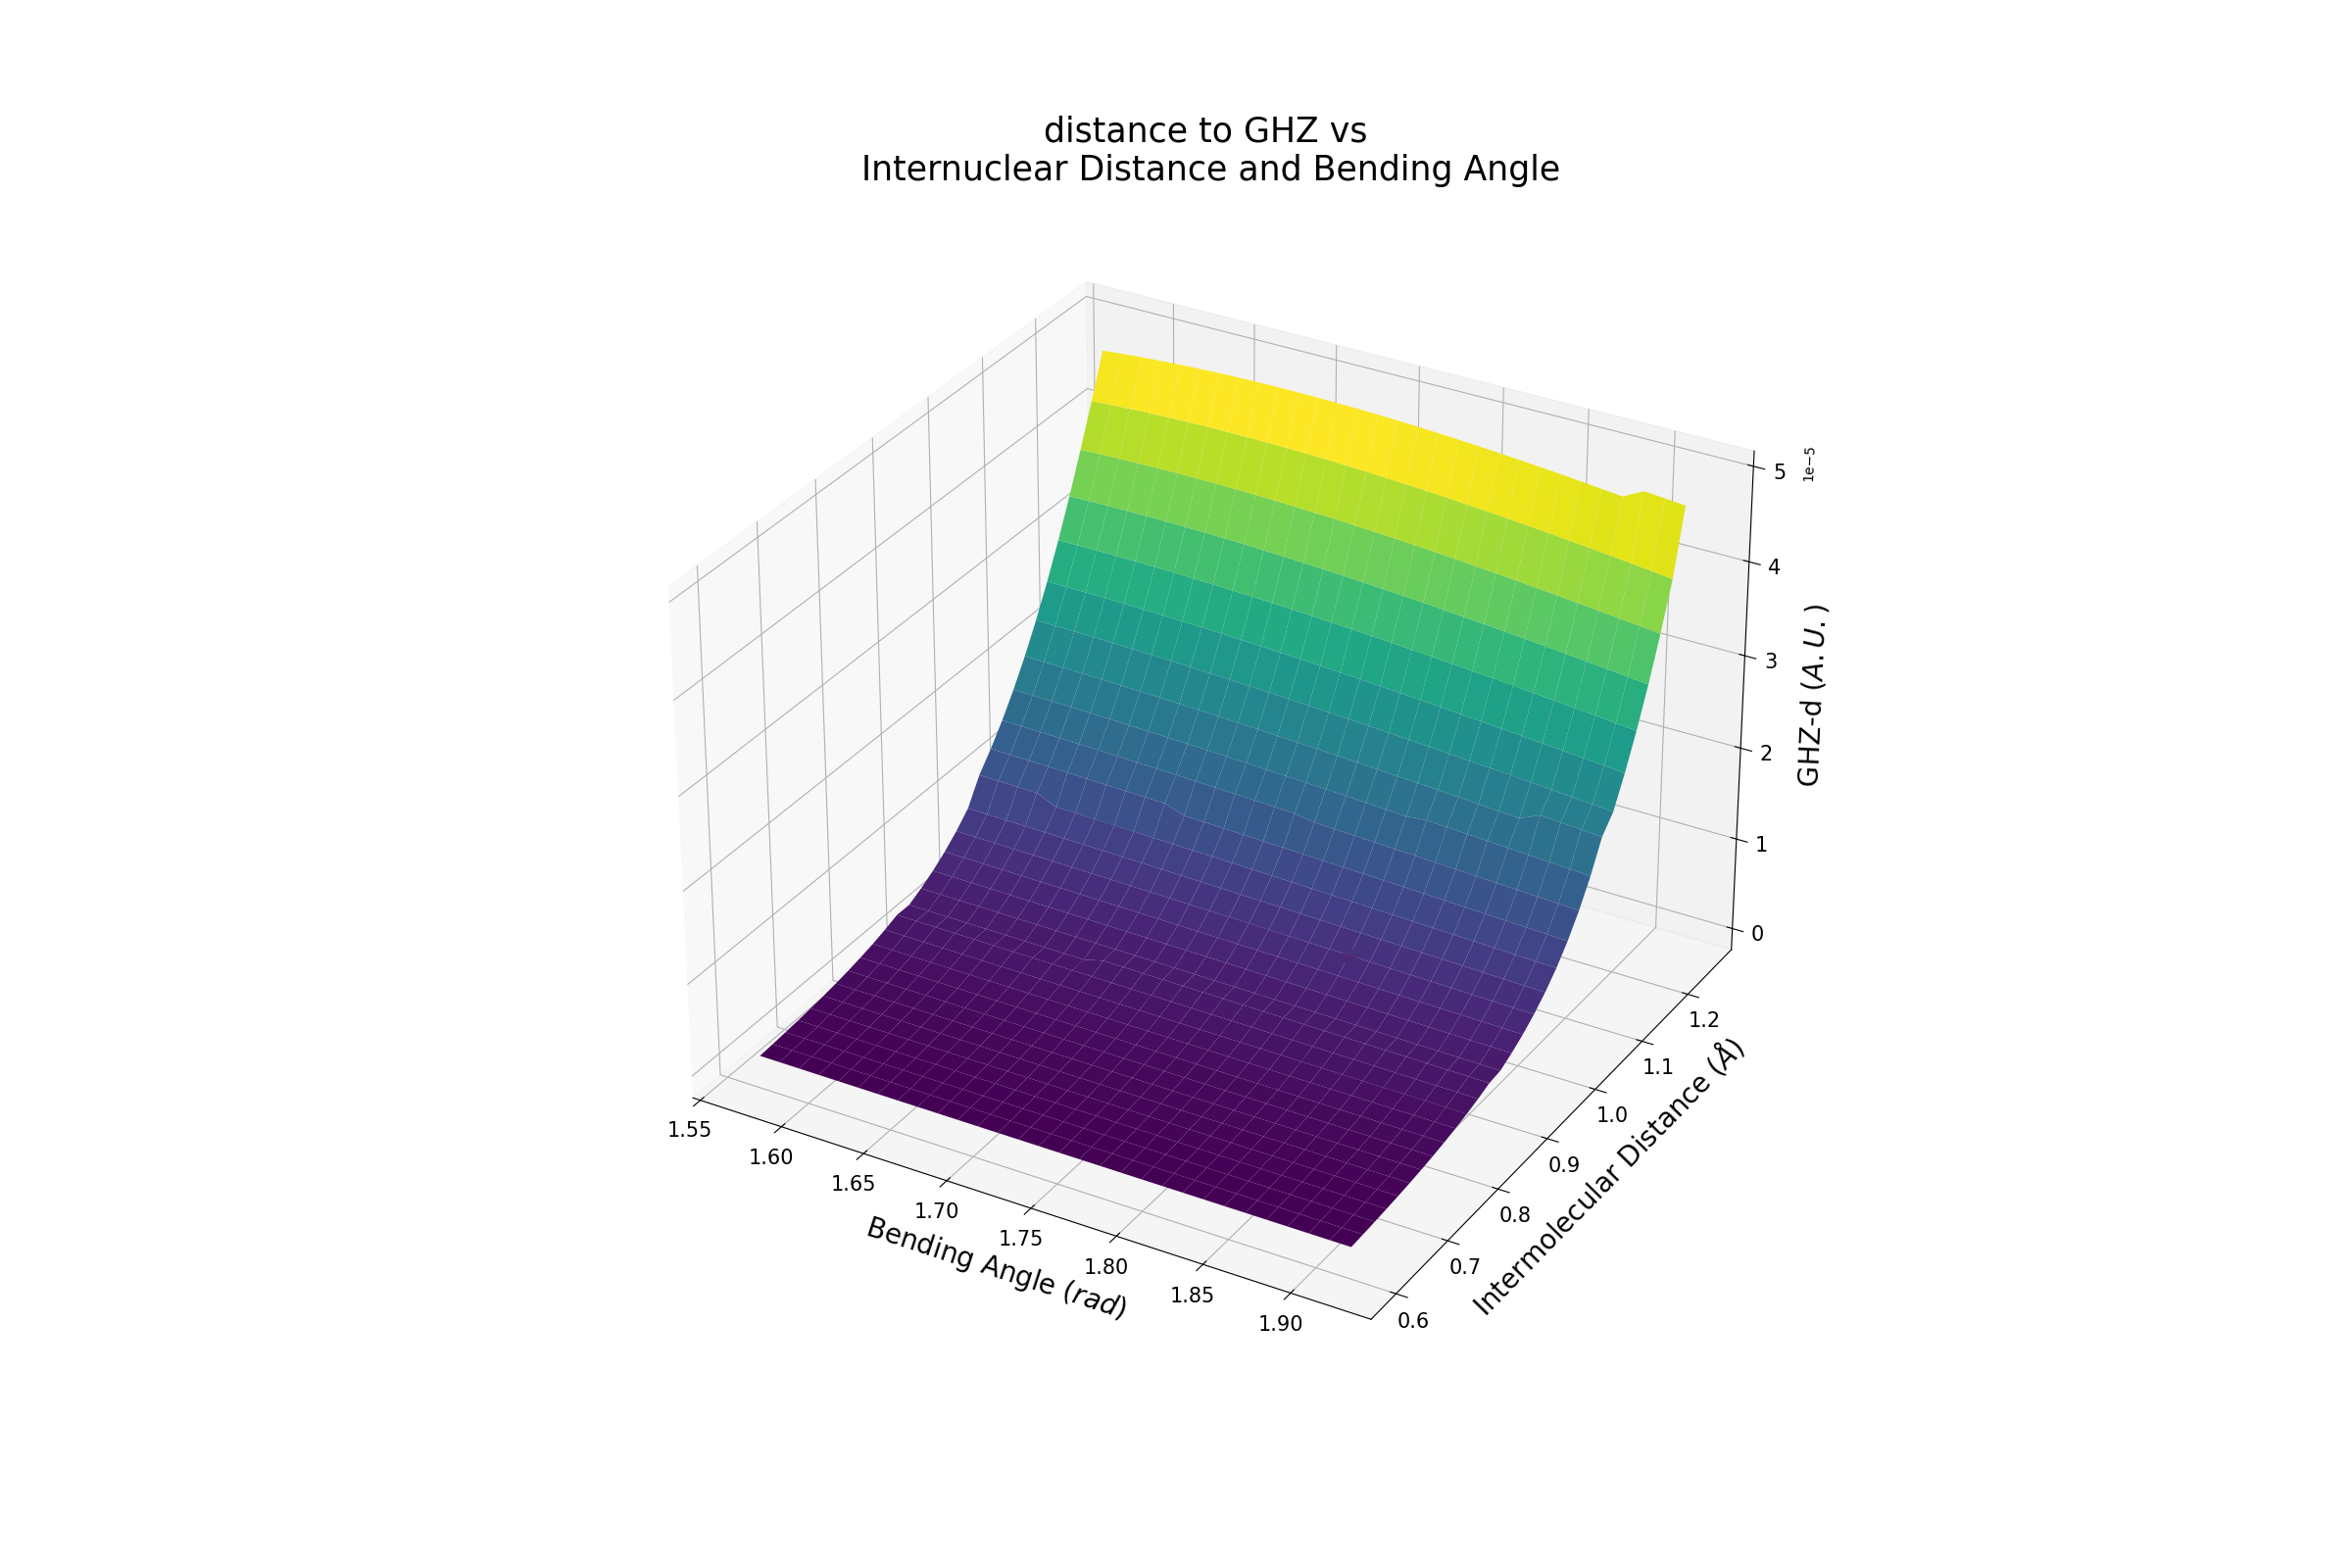

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

# Enable interactive mode
%matplotlib widget




fig = plt.figure(figsize=(24, 16))
ax = fig.add_subplot(111, projection='3d')



angles_grid, distances_grid = np.meshgrid(angles_interval, distances)

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method
energies = ghzmeasure_H2OV3

# Plot surface
surf = ax.plot_surface(angles_grid, distances_grid, energies, cmap='viridis', alpha= 1)

# Customize plot
ax.set_xlabel('\nBending Angle ($rad$)',fontsize= 20)
ax.set_ylabel('\nIntermolecular Distance ($\AA$)', fontsize= 20)
ax.set_zlabel('\n GHZ-d ($A.U.$)', fontsize= 20)
ax.set_title('distance to GHZ vs\n Internuclear Distance and Bending Angle', fontsize= 25)

point_z = energies[16][20]



ax.scatter(point_x, point_y, point_z, color='red', s=100)



plt.tick_params(axis='both', which='major', labelsize=15)  # Change the label size here

# Add color bar
#fig.colorbar(surf, ax=ax)

plt.show()